In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH_TO_PROJECT = '/content/drive/My Drive/Serious/'
# path to conll class as well as to conll data
PATH_TO_CONLL = PATH_TO_PROJECT + 'coNLL/'
PATH_TO_TAG2IDX = PATH_TO_CONLL + 'tag2idx.json'
PATH_TO_ONE_TAG2IDX = PATH_TO_CONLL + 'one_tag2idx.json'
PATH_TO_CHECKPOINT = PATH_TO_PROJECT + 'Models_results/'

### Installing all packages for colab

In [3]:
!pip install -r '/content/drive/My Drive/Serious/requirements.txt'

     |████████████████████████████████| 1.9MB 13.8MB/s 
     |████████████████████████████████| 634kB 52.1MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 3.3MB 46.9MB/s 
     |████████████████████████████████| 901kB 53.0MB/s 
     |████████████████████████████████| 266kB 57.3MB/s 
     |████████████████████████████████| 122kB 50.7MB/s 
     |████████████████████████████████| 133kB 59.0MB/s 
     |████████████████████████████████| 1.2MB 51.9MB/s 
     |████████████████████████████████| 2.1MB 46.7MB/s 
     |████████████████████████████████| 7.4MB 46.1MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 133kB 58.1MB/s 
     |████████████████████████████████| 163kB 60.6MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-

###Importing packages

In [4]:
import sys
sys.path.append(PATH_TO_PROJECT)
sys.path.append(PATH_TO_CONLL)

from importlib import reload
import conll as co

import data_loaders as dalo

from bert_config import *
from elmo_config import *

import model_utils as mu

In [5]:
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from transformers import BertForTokenClassification
from allennlp.modules.elmo import Elmo, batch_to_ids

from torchcrf import CRF

from sklearn.model_selection import KFold, ParameterGrid

from transformers import get_linear_schedule_with_warmup

import matplotlib
from matplotlib import pyplot as plt
import json

import gc

%matplotlib inline

Connect to device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
torch.cuda.empty_cache()

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)

### Preprocessing

In [7]:
conll = co.CoNLL_old(PATH_TO_CONLL)
for typ in conll.types:
    conll.split_text_label(typ)
conll.create_tag2idx(PATH_TO_TAG2IDX)
conll.create_idx2tag()

In [8]:
# with use it for evaluating on different tags
conll_one_tag = co.CoNLL(PATH_TO_CONLL)
# splitting raw data to sentences and labels
for typ in conll_one_tag.types:
    conll_one_tag.split_text_label(typ)

# define set of all labels
conll_one_tag.create_set_of_labels()

# for multihead model
conll_one_tag.create_tag2idx(PATH_TO_TAG2IDX)
conll_one_tag.create_idx2tag()

for typ in conll_one_tag.types:
    # for multiple heads of CRF layer
    conll_one_tag.create_one_labeled_data(typ)

    # creating one_tag2idx dictionary
    conll_one_tag.create_one_tag2idx(PATH_TO_ONE_TAG2IDX)
    conll_one_tag.create_idx2one_tag()

In [9]:
conll.idx2tag

{0: 'PAD',
 1: 'I-ORG',
 2: 'O',
 3: 'B-ORG',
 4: 'B-PER',
 5: 'B-MISC',
 6: 'I-PER',
 7: 'I-LOC',
 8: 'B-LOC',
 9: 'I-MISC'}

### Tokenization with BertTokenizer

BERT (Bidirectional Encoder Representations from Transformers) is a method of pretraining language representations. These vectors (representations) are used as high-quality feature inputs to downstream models. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them.

The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. We use the cased variate since it is well suited for NER.

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

### Creating dataloaders

In [ ]:
!pip uninstall protobuf -y
!pip uninstall google -y
!pip install google
!pip install protobuf
!pip install google-cloud

In [ ]:
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader_old(conll.sentences['train'],
                                                                            conll.labels['train'], conll.tag2idx,
                                                                            bert_tokenizer)

In [ ]:
# max len
train_dataset[0][0].shape

torch.Size([173])

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll.sentences['valid'],
                                                            conll.labels['valid'], conll.tag2idx,
                                                            bert_tokenizer, 'valid', desired_pad=train_dataset[0][0].shape[0])

### BERT & ELMo setup

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel.

### Define the model

In [10]:
def freeze_bert_layers(bert, num_of_trainable=0):
    for name, par in bert.named_parameters():
        if sum([str(i) in name for i in range(12-num_of_trainable, 12)]) == 0:
            par.requires_grad = False

In [11]:
class BEboC(nn.Module):
    """
    BERT+Elmo+biLSTM+one CRF
    """
    def __init__(self, hidden_size=128, num_labels=len(conll.tag2idx), elmo_layers=2,
                 bert_layers=1, concat_bert=True, num_of_trainable_bert_layers=0, bilstm_layers=1, dropout=0.5):
        """
        Creates model
        
        Parameters
        ----------
        hidden_size:
        num_labels:
        elmo_layers: int, default=2
            Num of ELMo layers to be considered
        bert_layers: int, default=1
            Num of final BERT hidden layers to be used as embedding vector.
        concat_bert: bool, default=True
            Whether to concat (True) or sum (False) last BERT hidden layers.
        num_of_trainable_bert_layers: int, default=0
            Num of trainable bert layers.
        bilstm_layers: int, default=1
        dropout: float, default=0
          Dropout value
        """
        super(BEboC, self).__init__()

        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.elmo_layers = elmo_layers
        self.bert_layers = bert_layers
        self.concat_bert = concat_bert
        self.num_of_trainable_bert_layers = num_of_trainable_bert_layers
        self.bilstm_layers = bilstm_layers
        self.dropout = dropout
        
        self.bert = BertForTokenClassification.from_pretrained(
                        BERT_MODEL,
                        output_hidden_states=True)
        
        #for pars in self.bert.parameters():
        #    pars.requires_grad = False
        freeze_bert_layers(self.bert, num_of_trainable=num_of_trainable_bert_layers)
        
        bert_embedding_dim = self.bert.config.to_dict()['hidden_size']

        self.elmo = Elmo(options_file, weight_file, self.elmo_layers, dropout=0, requires_grad=False)
        
        elmo_embedding_dim = 512 # it's always fixed

        if self.concat_bert:
          self.linear1 = nn.Linear(bert_embedding_dim*self.bert_layers+elmo_embedding_dim*self.elmo_layers, 1024)
        else:
          self.linear1 = nn.Linear(bert_embedding_dim+elmo_embedding_dim*self.elmo_layers, 1024)
        
        self.dp1 = nn.Dropout(dropout)

        self.bilstm = nn.LSTM(1024, self.hidden_size, self.bilstm_layers, bidirectional=True)
        
        self.dp2 = nn.Dropout(dropout)

        self.linear2 = nn.Linear(self.hidden_size*2, self.num_labels)

        self.crf = CRF(num_tags=self.num_labels, batch_first=True)
    
    def get_model_pars_dict(self):
        """
        Returns dict with described model's parameters.
        
        """
        pars = {}
        pars['hidden_size'] = self.hidden_size
        pars['num_labels'] = self.num_labels
        pars['elmo_layers'] = self.elmo_layers
        pars['bert_layers'] = self.bert_layers
        pars['concat_bert'] = int(self.concat_bert)
        pars['bilstm_layers'] = self.bilstm_layers

        return pars
    
    def forward(self, bert_ids, elmo_ids, attention_mask):
        """
        Forward propogate of model.
        
        Parameters
        ----------
        sequence:
        attention_mask:
        
        Returns
        -------
        Logits
        
        """

        bert_hiddens = self.bert(bert_ids, attention_mask=attention_mask)[1]
        elmo_hiddens = self.elmo(elmo_ids)

        if self.concat_bert:
            bert_embedding = torch.cat(bert_hiddens[-self.bert_layers:], dim=2)#[bert_hiddens[-i] for i in range(-1, -self.bert_layers-1, -1)], dim=0)
        else:
            emb_sum = 0
            for h in bert_hiddens[-self.bert_layers:]:
                emb_sum += h
            bert_embedding = emb_sum

        elmo_bert_embeddings = torch.clone(bert_embedding)

        for el_hi in elmo_hiddens['elmo_representations']:
            elmo_bert_embeddings = torch.cat((elmo_bert_embeddings, el_hi), dim=-1)

        linear1_output = nn.functional.relu(self.linear1(elmo_bert_embeddings))
        linear1_output = self.dp1(linear1_output)

        bilstm_output, (h_n, c_n) = self.bilstm(linear1_output)
        bilstm_output = self.dp2(bilstm_output)

        linear2_output = nn.functional.relu(self.linear2(bilstm_output))
        return linear2_output
    
    def init_weights(self):
        """
        Initializes models trainable weights (in bilstm and linear layers) 
        according to Xavier uniform distribution.

        """

        for name, param in model.named_parameters():
            if ('linear' in name or 'bilstm' in name) and \
            ('weight' in name) and \
            ('bert' not in name and 'elmo' not in name) and \
            param.requires_grad:
                torch.nn.init.xavier_uniform_(param)


### Model selection using grid

Let's use small train dataset with 1000 examples (instead of 14041) in train and 250 (instead of 3250) in validation

In [ ]:
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader_old(conll.sentences['train'][:1000],
                                                                            conll.labels['train'][:1000], conll.tag2idx,
                                                                            bert_tokenizer)

valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll.sentences['valid'][:250],
                                                            conll.labels['valid'][:250], conll.tag2idx,
                                                            bert_tokenizer, 'valid', desired_pad=train_dataset[0][0].shape[0])

In [ ]:
N_EPOCHS = 15
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
%time
param_grid = {
    'hidden_size': [512],
    'lr': [3e-4, 5e-4, 1e-3],
    'bert_layers': [2],
    'bilstm_layers': [1, 2],
    'dropout': [0, 0.25, 0.5],
    'max_grad_norm': [None, 228]
}


grid = ParameterGrid(param_grid)

results_dict = {}

for m, ps in enumerate(grid):
    print(f"Model #{m} of {len(grid)}")
    results_dict[m] = {}
    results_dict[m]['params'] = ps

    model = BEboC(hidden_size=ps['hidden_size'], bert_layers=ps['bert_layers'],
                  dropout=ps['dropout'])

    optimizer = AdamW(params=model.parameters(),lr=ps['lr'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    if device.type != 'cpu':
        model.to(device)

    torch.cuda.empty_cache()
    
    results = mu.train_old(model, train_dataloader, optimizer, conll_old.idx2tag, device,
                        scheduler, n_epoch=N_EPOCHS, max_grad_norm=ps['max_grad_norm'],
                        validate=True, valid_dataloader=valid_dataloader, 
                        save_model=False)
    

    _, _, valid_accuracies, valid_f1_scores = results

    results_dict[m]['valid_accs'] = valid_accuracies
    results_dict[m]['valid_f1s'] = valid_f1_scores
    

with open("/content/drive/My Drive/Serious/Models_results/dropout_results_dict.json", "w") as w:
    json.dump(results_dict, w)

In [ ]:
final_f1s = {k: v['valid_f1s'][-1] for k, v in results_dict.items()}
print(f'The best model is the {np.argmax(list(final_f1s.values()))} one.')
print(f'Its params: {results_dict[np.argmax(list(final_f1s.values()))]["params"]}')

The best model is the 15 one.
Its params: {'bert_layers': 2, 'bilstm_layers': 1, 'dropout': 0.5, 'hidden_size': 512, 'lr': 0.0005, 'max_grad_norm': 228}


After train for 15 epochs on small dataset the best result gave the model that concatenates two last bert layers, uses just 1 bilstm layer, dropout value 0.5 and has learning rate 5e-4, so let's train such model on all train data. Also, let's use now linear scheduler.

### Model gradients analysis

Grid search has shown us that it's a little bit better to use clipping of gradient. Let's inpect gradient values of pretrained model to find max grad norm value more carefully. 

In [ ]:
checkpoint = torch.load(PATH_TO_CHECKPOINT+'dropout_beboc.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
def get_grad_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2 
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [ ]:
model.to(device)

In [ ]:
model.train()
grad_norms = []

for batch in train_dataloader:
    if device.type != 'cpu':
            batch = tuple(t.to(device) for t in batch)
    b_bert_ids, b_elmo_ids, b_labels, b_input_mask = batch
    model.zero_grad()

    logits = model.forward(b_bert_ids, b_elmo_ids, b_input_mask.byte())
    loss = -1*model.crf.forward(logits, b_labels, mask=b_input_mask.byte())
    loss.backward()
    grad_norms.append(get_grad_norm(model))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


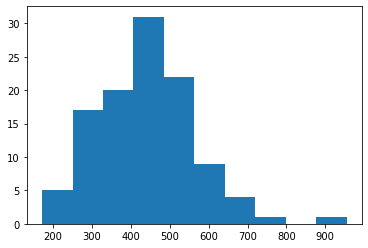

In [ ]:
_ = plt.hist(grad_norms)

In [ ]:
print(f'Mean gradient norm: {np.mean(grad_norms)}')

Mean gradient norm: 443.54006613919825


So, let's set max grad norm value to be 500 during training.

### Cross-validation with the best hyperparams on 5 folds

Fix some train parameters


In [ ]:
N_FOLDS = 5
RANDOM_SEED = 42
N_EPOCHS = 15
BATCH_SIZE = 128

In [ ]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER', 'MISC']

In [ ]:
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader_old(conll.sentences['train'],
                                                                            conll.labels['train'], conll.tag2idx,
                                                                            bert_tokenizer)

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll.sentences['valid'],
                                                            conll.labels['valid'], conll.tag2idx,
                                                            bert_tokenizer, 'valid', desired_pad=train_dataset[0][0].shape[0])

In [ ]:
all_tag_results = []
model_results = []

for i, (train_index, valid_index) in enumerate(kf.split(train_dataset)):
    print(f"FOLD #{i}\n")
    # train_dataset based on conll and defined above specially for multiple-head model input
    train_fold = torch.utils.data.Subset(train_dataset, train_index)
    valid_fold = torch.utils.data.Subset(train_dataset, valid_index)
    
    _train_dataloader = torch.utils.data.DataLoader(train_fold, batch_size=BATCH_SIZE)
    _valid_dataloader = torch.utils.data.DataLoader(valid_fold, batch_size=BATCH_SIZE)

    total_steps = len(train_fold) *  N_EPOCHS

    model = BEboC(hidden_size=512, num_labels=len(conll.tag2idx), bert_layers=2)
    model.to(device)

    optimizer = AdamW(params=model.parameters(),lr=5e-4)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_values, validation_loss_values, valid_accuracies, valid_f1_scores = mu.train_old(model, _train_dataloader, optimizer, conll.idx2tag, device, scheduler, n_epoch=N_EPOCHS,
                                                                                          max_grad_norm=500, valid_dataloader=_valid_dataloader, save_model=False)
    
    # evaluating on all validation data
    eval_loss, acc, f1 = mu.eval_old(model, _valid_dataloader, device, conll.idx2tag)
    model_results.append({'acc': acc, 'f1': f1})

    # evaluating on separate tags
    tag_results = {}
    for tag in TAG_NAMES:
        # old version of create dataloader function is very suitable here
        tag_train_dataset, _, _ = dalo.create_dataloader_old(conll_one_tag.sentences['train'],
                                                            conll_one_tag.one_tag_dict['train'][tag], conll_one_tag.tag2idx,
                                                            bert_tokenizer, desired_pad=train_dataset[0][0].shape[0])
        tag_valid_fold = torch.utils.data.Subset(tag_train_dataset, valid_index)
        tag_valid_dataloader = torch.utils.data.DataLoader(tag_valid_fold, batch_size=BATCH_SIZE)
        eval_loss, acc, f1 = mu.eval_old(model, tag_valid_dataloader, device, conll.idx2tag)
        
        tag_results[tag] = {'loss': eval_loss, 'acc': acc, 'f1': f1}
    
    print(f"tag_results:{tag_results}")
    all_tag_results.append(tag_results)

    # cleaning
    del model
    gc.collect()
    torch.cuda.empty_cache()

    with open(PATH_TO_CHECKPOINT+f"beboc_5folds/BEboC-5fold_tag_results_fold{i}.json", "w") as f:
        json.dump(tag_results, f)

    with open(PATH_TO_CHECKPOINT+f"beboc_5folds/BEboC-5fold_model_results_fold{i}.json", "w") as f:
        json.dump(model_results[-1], f)

#with open(PATH_TO_CHECKPOINT+"BEboC-5fold_tag_results.json", "w") as f:
#    json.dump(all_tag_results, f)

#with open(PATH_TO_CHECKPOINT+"BEboC-5fold_model_results.json", "w") as f:
#    json.dump(model_results, f)


### Final model train

In [ ]:
N_EPOCHS = 15

In [ ]:
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
model = BEboC(hidden_size=512, bert_layers=2, dropout=0.5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.init_weights()

In [ ]:
model.to(device)

In [ ]:
optimizer = AdamW(params=model.parameters(), lr=5e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

#if device.type != 'cpu':
#    model.to(device)

#train_losses, valid_losses, valid_accs, valid_f1s
results = mu.train_old(model, train_dataloader, optimizer, conll.idx2tag, device,
                        scheduler, n_epoch=N_EPOCHS, max_grad_norm=500,
                        valid_dataloader=valid_dataloader, 
                        save_path=PATH_TO_CHECKPOINT+'new_beboc.pth')

with open(PATH_TO_CHECKPOINT+'new_beboc_results.json', 'w') as f:
    json.dump(results, f)

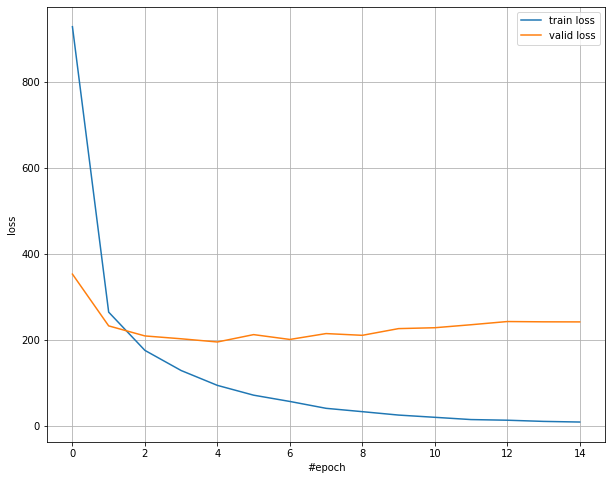

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(results[0], label='train loss')
plt.plot(results[1], label='valid loss')
plt.legend()
plt.grid()
plt.ylabel("loss")
plt.xlabel("#epoch")
plt.xticks(np.arange(0,15,2))
plt.show()

If we want to train model for more time

In [ ]:
checkpoint = torch.load(PATH_TO_CHECKPOINT+'new_beboc.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
N_EPOCHS = 25
total_steps = len(train_dataloader) *  N_EPOCHS

optimizer = AdamW(params=model.parameters(), lr=5e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)
  
model.train()

#train_losses, valid_losses, valid_accs, valid_f1s
results = mu.train_old(model, train_dataloader, optimizer, conll.idx2tag, device,
                        scheduler, n_epoch=N_EPOCHS, max_grad_norm=500, 
                        early_stopping_steps=10, valid_dataloader=valid_dataloader, 
                        save_path=PATH_TO_CHECKPOINT+'new_beboc_v1.pth')

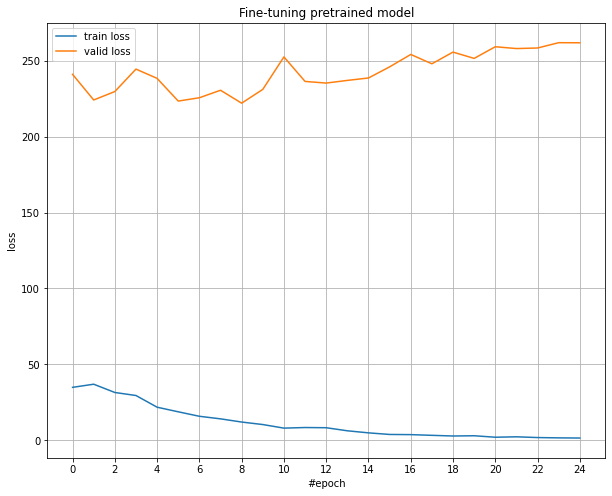

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(results[0], label='train loss')
plt.plot(results[1], label='valid loss')
plt.legend()
plt.grid()
plt.ylabel("loss")
plt.xlabel("#epoch")
plt.title('Fine-tuning pretrained model')
plt.xticks(np.arange(0,25,2))
plt.show()

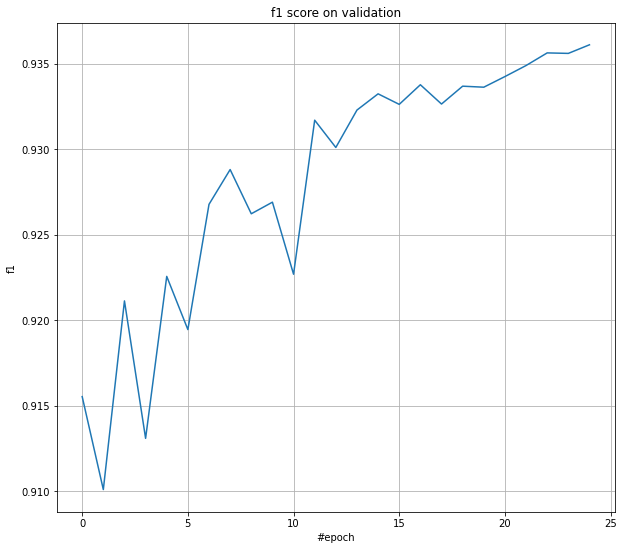

In [ ]:
fig = plt.figure(figsize=(10,9))
_ = plt.plot(results[3])
plt.grid()
plt.xlabel('#epoch')
plt.ylabel('f1')
plt.title('f1 score on validation')
plt.show()

If we want to evaluate the best model on the test set

In [ ]:
test_dataset, test_sampler, test_dataloader = dalo.create_dataloader_old(conll.sentences['test'],
                                                            conll.labels['test'], conll.tag2idx,
                                                            bert_tokenizer, 'test', desired_pad=train_dataset[0][0].shape[0])

In [ ]:
# eval model on the test data
mean_loss, mean_acc, mean_f1 = mu.eval_old(model, test_dataloader, device, conll.idx2tag)
print(f"test loss: {mean_loss}")
print(f"test accuracy: {mean_acc}")
print(f"test f1-score: {mean_f1}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


test loss: 525.2450199833622
test accuracy: 0.9720465559139938
test f1-score: 0.8861272208413882


___

### Load the model

In [ ]:
model = torch.load('/content/drive/My Drive/models/BERT_biLSTM_oneCRF.pth',
                   map_location=torch.device('cpu'))

In [ ]:
model = torch.load('/content/drive/My Drive/models/Elmo_BERT_biLSTM_oneCRF.pth',
                   map_location=torch.device('cpu'))

In [ ]:
def load_checkpoint(tokenizer_path, checkpoint_path):
    """Loads both tokenizer and our pretrained model"""
    tokenizer = tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    checkpoint = torch.load(checkpoint_path)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    #for parameter in model.parameters():
    #    parameter.requires_grad = False

    model.eval()
    return tokenizer, model

In [ ]:
tokenizer, model = load_checkpoint('/content/drive/My Drive/models/ElMo_BERT_biLSTM_oneCRF_19_tokenizer.pth',
                                     '/content/drive/My Drive/models/ElMo_BERT_biLSTM_oneCRF_19_state_dict.pth')

In [ ]:
tokenizer.save_pretrained(f'/content/drive/My Drive/models/ElMo_BERT_biLSTM_oneCRF_19_tokenizer.pth')
checkpoint = {'model': BEboC(hidden_size=512, bert_layers=2),
              'state_dict': model.state_dict(), 
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint,
            f'/content/drive/My Drive/models/ElMo_BERT_biLSTM_oneCRF_19_state_dict.pth')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
train_dataset, train_sampler, train_dataloader = create_dataloader(tokenizer, train_data, train_labels)

In [ ]:
for s in train_dataset:
  max_seq_len = s[1].shape[0]
  break

In [ ]:
test_dataset, test_sampler, test_dataloader = create_dataloader(tokenizer, test_data, test_labels,
                                                                   datatype='test',
                                                                   desired_pad=max_seq_len)

In [ ]:
model.to(device)
model.eval()
test_losses = []
true_labels = []
pred_labels = []
for step, batch in enumerate(test_dataloader):
    # add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    b_elmo_ids, b_bert_ids, b_input_mask, b_labels = batch
    batch_true_labels = b_labels
    for bl in batch_true_labels.detach().cpu().tolist():
      tag_names = [idx2tag[i] for i in bl if idx2tag[i] != 'PAD']
      true_labels.append(tag_names)
    
    # Always clear any previously calculated gradients before performing a backward pass.
    # forward pass
    # This will return the loss (rather than the model output)
    # because we have provided the `labels`.
    with torch.no_grad():
        logits = model.forward(b_elmo_ids, b_bert_ids, b_input_mask.byte())
        loss = model.crf.forward(logits, b_labels, b_input_mask.byte())
        test_losses.append(loss.item())
        tags = model.crf.decode(logits, b_input_mask.byte())
    for t in tags:
      tag_names = [idx2tag[i] for i in t]
      pred_labels.append(tag_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
f1_score(true_labels, pred_labels)

0.8405783838198957

### Evaluate model on tags separately

In [ ]:
checkpoint = torch.load(PATH_TO_CHECKPOINT+'new_beboc.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.to(device)

Evaluating on the entire validation dataset

In [ ]:
# 173 because I remember this value (max len from the training)
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, datatype='valid', desired_pad=173)

In [ ]:
mu.eval_old(model, valid_dataloader, device, conll.idx2tag)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


(261.8769278893104, 0.9857753062540296, 0.9361052489784921)

So, f1-score on the entire validation dataset is 0.936

Let's evaluate the old model on just PER entity

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll_one_tag.sentences['valid'],
                                                                            conll_one_tag.one_tag_dict['valid']['PER'], conll.tag2idx,
                                                                            bert_tokenizer, datatype='valid', desired_pad=173)

In [ ]:
mu.eval_old(model, valid_dataloader, device, conll.idx2tag)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


(4335.669142503005, 0.8670481409843112, 0.4411235644112356)

ORG

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll_one_tag.sentences['valid'],
                                                                            conll_one_tag.one_tag_dict['valid']['ORG'], conll.tag2idx,
                                                                            bert_tokenizer, datatype='valid', desired_pad=173)

In [ ]:
mu.eval_old(model, valid_dataloader, device, conll.idx2tag)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


(5549.048011192908, 0.8306871910595315, 0.36074347291531067)

LOC

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll_one_tag.sentences['valid'],
                                                                            conll_one_tag.one_tag_dict['valid']['LOC'], conll.tag2idx,
                                                                            bert_tokenizer, datatype='valid', desired_pad=173)

In [ ]:
mu.eval_old(model, valid_dataloader, device, conll.idx2tag)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


(5305.535513070913, 0.8349854932301741, 0.46964769647696475)

The last values above are f1-scores:

'PER' - 0.4411235644112356

'ORG' - 0.36074347291531067

'LOC' - 0.46964769647696475

### Train BEboC on data with three labels (without MISC).

But CRF is still knows that there is another tag that he doesn't meet during this training (it is inpossible to add new tags to CRF)

In [ ]:
labels_w_misc = {}
for typ in ['train', 'valid']:
    labels_w_misc[typ] = [[l if 'MISC' not in l else 'O' for l in sen] for sen in conll.labels[typ]]

In [ ]:
print(conll.labels['train'][0])
print(labels_w_misc['train'][0])

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader_old(conll.sentences['train'],
                                                                            labels_w_misc['train'], conll.tag2idx,
                                                                            bert_tokenizer)

valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader_old(conll.sentences['valid'],
                                                            labels_w_misc['valid'], conll.tag2idx,
                                                            bert_tokenizer, 'valid', desired_pad=train_dataset[0][0].shape[0])

In [ ]:
N_EPOCHS = 15
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
model = BEboC(hidden_size=512, bert_layers=2, dropout=0.5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
reload(mu)

<module 'model_utils' from '/content/drive/My Drive/Serious/model_utils.py'>

In [ ]:
model.to(device)

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=5e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

#train_losses, valid_losses, valid_accs, valid_f1s
results = mu.train_old(model, train_dataloader, optimizer, conll.idx2tag, device,
                       scheduler, n_epoch=N_EPOCHS, max_grad_norm=500,
                       validate=True, valid_dataloader=valid_dataloader, 
                       save_path=PATH_TO_CHECKPOINT+'Beboc_without_misc.pth')

### Continue to train BEboC on data with MISC

Now let's try to keep 85% of examples with one or more tags MISC and 15% without it. So, we would simulate the real case of receiving new data with new tag.

In [ ]:
checkpoint = torch.load(PATH_TO_CHECKPOINT+'Beboc_without_misc.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
indexes_with_misc = [i for i, s in enumerate(conll.labels['train']) if 'B-MISC' in s]
indexes_without_misc = [i for i in range(len(conll.labels['train'])) if i not in indexes_with_misc]

In [ ]:
print(f"# sentences with MISC: {len(indexes_with_misc)}")
print(f"# sentences without MISC: {len(indexes_without_misc)}")

# sentences with MISC: 2698
# sentences without MISC: 11343


Also, let's consider multiple "random" cases.

In [ ]:
BATCH_SIZE=32
RANDOM_SEED=42
N_EPOCHS = 15

In [ ]:
results_dict = {}
for seed in [1234, 12345]:
    print(f"SEED:{seed}")
    np.random.seed(seed)
    results_dict[seed] = {}

    for n_train_samples in range(100, 351, 50):
        print(f"NUMBER OF TRAIN SAMPLES: {n_train_samples}")
        
        torch.cuda.empty_cache()

        model = checkpoint['model']
        model.load_state_dict(checkpoint['state_dict'])
        
        model.train()
        
        # I just remember that max sequence length in train is 173
        all_valid_dataset, all_valid_sampler, all_valid_dataloader = dalo.create_dataloader_old(conll.sentences['valid'],
                                                                              conll.labels['valid'], conll.tag2idx,
                                                                              bert_tokenizer, 'valid', desired_pad=173)
        
        # train indexes
        n_train_with_misc = int(n_train_samples*0.85)
        train_misk_indexes = np.random.choice(indexes_with_misc, n_train_with_misc)
        train_nmisk_indexes = np.random.choice(indexes_without_misc, n_train_samples-n_train_with_misc)
        train_indexes = np.append(train_misk_indexes, train_nmisk_indexes)

        # let's create small validation data with the same proportion of MISC samples from the train data
        n_valid_samples = int(n_train_samples/4)
        _idxes_with_misc = [i for i in indexes_with_misc if i not in train_misk_indexes]
        _idxes_without_misc = [i for i in indexes_without_misc if i not in train_nmisk_indexes]

        # validation indexes
        n_valid_with_misc = int(n_valid_samples*0.85)
        valid_misk_indexes = np.random.choice(_idxes_with_misc, n_valid_with_misc)
        valid_nmisk_indexes = np.random.choice(_idxes_without_misc, n_valid_samples-n_valid_with_misc)
        valid_indexes = np.append(valid_misk_indexes, valid_nmisk_indexes)

        train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer,
                                                                      desired_pad=173, batch_size=BATCH_SIZE,
                                                                      indexes=train_indexes)
        
        valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer,
                                                                            desired_pad=173, batch_size=BATCH_SIZE,
                                                                            indexes=valid_indexes)
        
        total_steps = len(train_dataloader) *  N_EPOCHS

        optimizer = AdamW(params=model.parameters(),lr=5e-4)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        if device.type != 'cpu':
            model.to(device)

        results = mu.train_old(model, train_dataloader, optimizer, conll.idx2tag, device,
                        scheduler, n_epoch=N_EPOCHS, max_grad_norm=500,
                        validate=True, valid_dataloader=valid_dataloader, 
                        save_model=False)
        
        _, _, valid_accuracies, valid_f1_scores = results

        results_dict[seed][n_train_samples] = {}
        results_dict[seed][n_train_samples]['small_valid_accs'] = valid_accuracies
        results_dict[seed][n_train_samples]['small_valid_f1s'] = valid_f1_scores

        # eval model on the all validation data
        mean_loss, mean_acc, mean_f1 = mu.eval_old(model, all_valid_dataloader, device, conll.idx2tag)
        print(f"validation loss: {mean_loss}")
        print(f"validation accuracy: {mean_acc}")
        print(f"validation f1-score: {mean_f1}")

        results_dict[seed][n_train_samples]["all_valid_loss"] = mean_loss
        results_dict[seed][n_train_samples]["all_valid_acc"] = mean_acc
        results_dict[seed][n_train_samples]["all_valid_f1"] = mean_f1

        # eval model on every tag separately
        results_dict[seed][n_train_samples]['tags_results'] = {}
        for tag in ['LOC', 'PER', 'ORG', 'MISC']:
            tag_dataset, tag_sampler, tag_dataloader = dalo.create_dataloader_old(conll_one_tag.sentences['valid'],
                                                                              conll_one_tag.one_tag_dict['valid']['ORG'], conll.tag2idx,
                                                                              bert_tokenizer, datatype='valid', desired_pad=173)
            loss, acc, f1 = mu.eval_old(model, tag_dataloader, device, conll.idx2tag)
            results_dict[seed][n_train_samples]['tags_results'][tag] = {'loss': loss, 'acc': acc, 'f1': f1}

    with open(PATH_TO_CHECKPOINT+f"misc_finetune/results_seed{seed}.json", "w") as f:
        json.dump(results_dict[seed], f)

# Train on a half of training set

In [12]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)
PAD_LEN = 173 #I use the old value 

In [13]:
# we are training on three-labels data
labels_w_misc = {}
for typ in ['train', 'valid']:
    labels_w_misc[typ] = [[l if 'MISC' not in l else 'O' for l in sen] for sen in conll.labels[typ]]

In [14]:
half_train_len = int(len(conll.sentences['train'])/2)

train_dataset, train_sampler, train_dataloader = dalo.create_dataloader_old(conll.sentences['train'][half_train_len:],
                                                                            labels_w_misc['train'][half_train_len:], 
                                                                            conll.tag2idx,
                                                                            bert_tokenizer)

## K-fold fot multilabel model

In [15]:
N_FOLDS = 5
RANDOM_SEED = 42
N_EPOCHS = 40
BATCH_SIZE = 128

In [16]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
all_tag_results = []
model_results = []

for i, (train_index, valid_index) in enumerate(kf.split(train_dataset)):
    if i < 1:
        continue
    print(f"FOLD #{i}\n")
    # train_dataset based on conll and defined above specially for multiple-head model input
    train_fold = torch.utils.data.Subset(train_dataset, train_index)
    valid_fold = torch.utils.data.Subset(train_dataset, valid_index)
    
    _train_dataloader = torch.utils.data.DataLoader(train_fold, batch_size=BATCH_SIZE)
    _valid_dataloader = torch.utils.data.DataLoader(valid_fold, batch_size=BATCH_SIZE)

    total_steps = len(train_fold) *  N_EPOCHS

    model = BEboC(hidden_size=512, num_labels=len(conll.tag2idx), bert_layers=2,
                  num_of_trainable_bert_layers=1, dropout=0.5)
    model.init_weights()
    model.to(device)

    optimizer = AdamW(params=model.parameters(),lr=5e-4)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_values, valid_loss_values, valid_accuracies, valid_f1_scores = mu.train_old(model, _train_dataloader, optimizer, conll.idx2tag, device, scheduler, n_epoch=N_EPOCHS,
                                                                                          max_grad_norm=500, valid_dataloader=_valid_dataloader, save_path=PATH_TO_CHECKPOINT+'temporal_beboc.pth')
    
    model_results.append({'losses': loss_values, 'valid_losses': valid_loss_values, 'valid_accs': valid_accuracies, 'valid_f1s': valid_f1_scores})
    # loading the best model
    checkpoint = torch.load(PATH_TO_CHECKPOINT+'temporal_beboc.pth')
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])

    # evaluating on separate tags
    tag_results = {}
    for tag in TAG_NAMES:
        # old version of create dataloader function is very suitable here
        tag_train_dataset, _, _ = dalo.create_dataloader_old(conll_one_tag.sentences['train'],
                                                            conll_one_tag.one_tag_dict['train'][tag], conll_one_tag.tag2idx,
                                                            bert_tokenizer, desired_pad=PAD_LEN)
        tag_valid_fold = torch.utils.data.Subset(tag_train_dataset, valid_index)
        tag_valid_dataloader = torch.utils.data.DataLoader(tag_valid_fold, batch_size=BATCH_SIZE)
        eval_loss, acc, f1 = mu.eval_old(model, tag_valid_dataloader, device, conll.idx2tag)
        
        tag_results[tag] = {'loss': eval_loss, 'acc': acc, 'f1': f1}
    
    print(f"tag_results:{tag_results}")
    all_tag_results.append(tag_results)

    # cleaning
    del model
    gc.collect()
    torch.cuda.empty_cache()

    with open(PATH_TO_CHECKPOINT+f"beboc_5folds_half_train_second/BEboC-5fold_tag_results_fold{i}.json", "w") as f:
        json.dump(tag_results, f)

    with open(PATH_TO_CHECKPOINT+f"beboc_5folds_half_train_second/BEboC-5fold_model_results_fold{i}.json", "w") as f:
        json.dump(model_results[-1], f)

FOLD #1



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


Epoch #0


 23%|██▎       | 10/44 [00:30<01:44,  3.07s/it]


9: avg loss per batch: 2486.95654296875



 45%|████▌     | 20/44 [01:02<01:16,  3.19s/it]


19: avg loss per batch: 1760.6346724660773



 68%|██████▊   | 30/44 [01:35<00:47,  3.37s/it]


29: avg loss per batch: 1504.4768466291757



 91%|█████████ | 40/44 [02:09<00:13,  3.34s/it]


39: avg loss per batch: 1310.9898133889224



100%|██████████| 44/44 [02:21<00:00,  3.22s/it]


Average train loss: 1216.587158203125
Validation loss: 677.4966291947799
Validation accuracy: 0.93249932499325
Validation F1-score: 0.6173391365721679



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #1


 23%|██▎       | 10/44 [00:33<01:55,  3.39s/it]


9: avg loss per batch: 639.1452857123481



 45%|████▌     | 20/44 [01:06<01:18,  3.27s/it]


19: avg loss per batch: 579.9317586798417



 68%|██████▊   | 30/44 [01:39<00:46,  3.30s/it]


29: avg loss per batch: 583.1082305908203



 91%|█████████ | 40/44 [02:13<00:13,  3.38s/it]


39: avg loss per batch: 564.3308758857922



100%|██████████| 44/44 [02:25<00:00,  3.32s/it]


Average train loss: 536.0004657398571
Validation loss: 462.862754128196
Validation accuracy: 0.952419524195242
Validation F1-score: 0.7359962734365901



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #2


 23%|██▎       | 10/44 [00:33<01:53,  3.35s/it]


9: avg loss per batch: 476.5763753255208



 45%|████▌     | 20/44 [01:06<01:19,  3.30s/it]


19: avg loss per batch: 463.04706934878703



 68%|██████▊   | 30/44 [01:39<00:46,  3.31s/it]


29: avg loss per batch: 461.01418541217674



 91%|█████████ | 40/44 [02:13<00:13,  3.38s/it]


39: avg loss per batch: 442.5711360833584



100%|██████████| 44/44 [02:26<00:00,  3.32s/it]


Average train loss: 421.4095098322088
Validation loss: 449.170146595348
Validation accuracy: 0.959079590795908
Validation F1-score: 0.7694303573534614



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #3


 23%|██▎       | 10/44 [00:33<01:53,  3.33s/it]


9: avg loss per batch: 381.4192403157552



 45%|████▌     | 20/44 [01:06<01:19,  3.29s/it]


19: avg loss per batch: 357.9963659989206



 68%|██████▊   | 30/44 [01:39<00:46,  3.30s/it]


29: avg loss per batch: 339.07178471006193



 91%|█████████ | 40/44 [02:12<00:13,  3.37s/it]


39: avg loss per batch: 313.8965098063151



100%|██████████| 44/44 [02:25<00:00,  3.31s/it]


Average train loss: 293.42358363758433
Validation loss: 284.495512528853
Validation accuracy: 0.973089730897309
Validation F1-score: 0.8476756887971841



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #4


 23%|██▎       | 10/44 [00:33<01:53,  3.34s/it]


9: avg loss per batch: 206.558224995931



 45%|████▌     | 20/44 [01:06<01:19,  3.29s/it]


19: avg loss per batch: 215.93742812307258



 68%|██████▊   | 30/44 [01:39<00:46,  3.30s/it]


29: avg loss per batch: 233.4064231083311



 91%|█████████ | 40/44 [02:13<00:13,  3.36s/it]


39: avg loss per batch: 225.4885512131911



100%|██████████| 44/44 [02:25<00:00,  3.32s/it]


Average train loss: 212.96266954595393
Validation loss: 251.0964619029652
Validation accuracy: 0.977739777397774
Validation F1-score: 0.8740043446777698



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #5


 23%|██▎       | 10/44 [00:33<01:53,  3.34s/it]


9: avg loss per batch: 156.07632107204861



 45%|████▌     | 20/44 [01:06<01:19,  3.30s/it]


19: avg loss per batch: 158.91543057090357



 68%|██████▊   | 30/44 [01:39<00:46,  3.30s/it]


29: avg loss per batch: 163.26568998139481



 91%|█████████ | 40/44 [02:13<00:13,  3.37s/it]


39: avg loss per batch: 167.363283206255



100%|██████████| 44/44 [02:25<00:00,  3.31s/it]


Average train loss: 157.81039359352806


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 275.6292003284801
Validation accuracy: 0.9747997479974799
Validation F1-score: 0.8524271844660194


Epoch #6


 23%|██▎       | 10/44 [00:33<01:52,  3.31s/it]


9: avg loss per batch: 124.89684592352972



 45%|████▌     | 20/44 [01:05<01:18,  3.28s/it]


19: avg loss per batch: 128.765179081967



 68%|██████▊   | 30/44 [01:39<00:46,  3.31s/it]


29: avg loss per batch: 130.34296022612472



 91%|█████████ | 40/44 [02:12<00:13,  3.37s/it]


39: avg loss per batch: 123.98879354428023



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 121.14970601688732


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 313.62203840775925
Validation accuracy: 0.97389973899739
Validation F1-score: 0.8453379378391712


Epoch #7


 23%|██▎       | 10/44 [00:33<01:52,  3.31s/it]


9: avg loss per batch: 116.56175231933594



 45%|████▌     | 20/44 [01:06<01:19,  3.30s/it]


19: avg loss per batch: 116.10074535169099



 68%|██████▊   | 30/44 [01:39<00:46,  3.33s/it]


29: avg loss per batch: 112.60970266934099



 91%|█████████ | 40/44 [02:12<00:13,  3.38s/it]


39: avg loss per batch: 110.73394863422101



100%|██████████| 44/44 [02:25<00:00,  3.31s/it]


Average train loss: 106.09074791994962


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 291.2181327126243
Validation accuracy: 0.977109771097711
Validation F1-score: 0.8633146204539908


Epoch #8


 23%|██▎       | 10/44 [00:33<01:52,  3.32s/it]


9: avg loss per batch: 93.35723283555772



 45%|████▌     | 20/44 [01:06<01:19,  3.30s/it]


19: avg loss per batch: 107.85344033492238



 68%|██████▊   | 30/44 [01:39<00:46,  3.29s/it]


29: avg loss per batch: 107.66216896320212



 91%|█████████ | 40/44 [02:12<00:13,  3.36s/it]


39: avg loss per batch: 104.57184121547601



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 98.34828662872314


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 290.1838642467152
Validation accuracy: 0.9768097680976809
Validation F1-score: 0.8708708708708708


Epoch #9


 23%|██▎       | 10/44 [00:32<01:52,  3.31s/it]


9: avg loss per batch: 99.56906933254666



 45%|████▌     | 20/44 [01:05<01:18,  3.29s/it]


19: avg loss per batch: 99.18765800877621



 68%|██████▊   | 30/44 [01:39<00:46,  3.31s/it]


29: avg loss per batch: 113.31802946945717



 91%|█████████ | 40/44 [02:12<00:13,  3.37s/it]


39: avg loss per batch: 106.88271194849258



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 102.05103874206543


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 270.1384360573509
Validation accuracy: 0.9768097680976809
Validation F1-score: 0.8649934578327584


Epoch #10


 23%|██▎       | 10/44 [00:33<01:52,  3.31s/it]


9: avg loss per batch: 91.35507329305013



 45%|████▌     | 20/44 [01:06<01:19,  3.29s/it]


19: avg loss per batch: 79.88241055137233



 68%|██████▊   | 30/44 [01:39<00:46,  3.31s/it]


29: avg loss per batch: 81.79288324816474



 91%|█████████ | 40/44 [02:12<00:13,  3.36s/it]


39: avg loss per batch: 83.28343352293356



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 77.06969300183383
Validation loss: 271.51417264071375
Validation accuracy: 0.9790297902979029
Validation F1-score: 0.8783751493428912



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #11


 23%|██▎       | 10/44 [00:33<01:53,  3.32s/it]


9: avg loss per batch: 87.64711464775934



 45%|████▌     | 20/44 [01:06<01:18,  3.29s/it]


19: avg loss per batch: 83.00128715916684



 68%|██████▊   | 30/44 [01:39<00:46,  3.29s/it]


29: avg loss per batch: 77.70484213993467



 91%|█████████ | 40/44 [02:12<00:13,  3.36s/it]


39: avg loss per batch: 78.31772104899089



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 72.5168966813521
Validation loss: 290.42263932661575
Validation accuracy: 0.9790597905979059
Validation F1-score: 0.8906365200294913



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #12


 23%|██▎       | 10/44 [00:33<01:53,  3.32s/it]


9: avg loss per batch: 64.85418701171875



 45%|████▌     | 20/44 [01:06<01:18,  3.29s/it]


19: avg loss per batch: 55.26800035175524



 68%|██████▊   | 30/44 [01:39<00:46,  3.29s/it]


29: avg loss per batch: 54.39473553361564



 91%|█████████ | 40/44 [02:12<00:13,  3.35s/it]


39: avg loss per batch: 54.465059133676384



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 51.16462603482333
Validation loss: 272.86912328546697
Validation accuracy: 0.98139981399814
Validation F1-score: 0.9006429697925512



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #13


 23%|██▎       | 10/44 [00:33<01:53,  3.33s/it]


9: avg loss per batch: 37.083246019151474



 45%|████▌     | 20/44 [01:06<01:18,  3.28s/it]


19: avg loss per batch: 40.83727164017527



 68%|██████▊   | 30/44 [01:39<00:46,  3.29s/it]


29: avg loss per batch: 46.371583741286706



 91%|█████████ | 40/44 [02:12<00:13,  3.36s/it]


39: avg loss per batch: 46.50750693296775



100%|██████████| 44/44 [02:25<00:00,  3.31s/it]


Average train loss: 43.0408107584173


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 264.3381819291548
Validation accuracy: 0.981519815198152
Validation F1-score: 0.8987403100775194


Epoch #14


 23%|██▎       | 10/44 [00:32<01:52,  3.30s/it]


9: avg loss per batch: 37.07959323459201



 45%|████▌     | 20/44 [01:05<01:19,  3.29s/it]


19: avg loss per batch: 33.93120574951172



 68%|██████▊   | 30/44 [01:38<00:46,  3.30s/it]


29: avg loss per batch: 36.36264998337318



 91%|█████████ | 40/44 [02:12<00:13,  3.36s/it]


39: avg loss per batch: 36.47023714505709



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 35.064410122958094


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 263.0878282026811
Validation accuracy: 0.980979809798098
Validation F1-score: 0.8969594594594593


Epoch #15


 23%|██▎       | 10/44 [00:32<01:52,  3.30s/it]


9: avg loss per batch: 39.737708197699654



 45%|████▌     | 20/44 [01:05<01:19,  3.29s/it]


19: avg loss per batch: 42.27552052548057



 68%|██████▊   | 30/44 [01:38<00:46,  3.30s/it]


29: avg loss per batch: 41.35971161414837



 91%|█████████ | 40/44 [02:12<00:13,  3.35s/it]


39: avg loss per batch: 42.191209548558945



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 40.248365055431016


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 299.65948763760656
Validation accuracy: 0.9800498004980049
Validation F1-score: 0.8937447472685797


Epoch #16


 23%|██▎       | 10/44 [00:33<01:52,  3.32s/it]


9: avg loss per batch: 49.68194876776801



 45%|████▌     | 20/44 [01:05<01:18,  3.27s/it]


19: avg loss per batch: 44.21763731303968



 68%|██████▊   | 30/44 [01:39<00:46,  3.32s/it]


29: avg loss per batch: 44.268513251995216



 91%|█████████ | 40/44 [02:12<00:13,  3.37s/it]


39: avg loss per batch: 43.38651833167443



100%|██████████| 44/44 [02:25<00:00,  3.31s/it]


Average train loss: 40.3805046081543


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 278.0300001664595
Validation accuracy: 0.98079980799808
Validation F1-score: 0.8972644376899697


Epoch #17


 23%|██▎       | 10/44 [00:32<01:52,  3.30s/it]


9: avg loss per batch: 37.211993323432075



 45%|████▌     | 20/44 [01:05<01:18,  3.29s/it]


19: avg loss per batch: 34.91637842278732



 68%|██████▊   | 30/44 [01:38<00:46,  3.31s/it]


29: avg loss per batch: 35.274552970096984



 91%|█████████ | 40/44 [02:12<00:13,  3.36s/it]


39: avg loss per batch: 36.461927267221306



100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Average train loss: 36.06552444804799
Validation loss: 289.5761878273704
Validation accuracy: 0.981789817898179
Validation F1-score: 0.9042591918456498



  0%|          | 0/44 [00:00<?, ?it/s]


Epoch #18


 23%|██▎       | 10/44 [00:33<01:53,  3.35s/it]


9: avg loss per batch: 36.01833724975586



 45%|████▌     | 20/44 [01:06<01:19,  3.31s/it]


19: avg loss per batch: 34.939490468878496



 68%|██████▊   | 30/44 [01:39<00:46,  3.31s/it]


29: avg loss per batch: 33.77858786747373



 91%|█████████ | 40/44 [02:13<00:13,  3.38s/it]


39: avg loss per batch: 32.25137260632637



100%|██████████| 44/44 [02:26<00:00,  3.32s/it]


Average train loss: 32.1160441311923


  0%|          | 0/44 [00:00<?, ?it/s]

Validation loss: 333.47409889914775
Validation accuracy: 0.976269762697627
Validation F1-score: 0.8710743801652893


Epoch #19


 23%|██▎       | 10/44 [00:32<01:52,  3.31s/it]


9: avg loss per batch: 31.91742494371202



 34%|███▍      | 15/44 [00:49<01:35,  3.31s/it]

## Extra

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
y_true_1 = ['B-PER', 'I-PER', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']
y_pred_1 = ['B-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']

y_true_2 = ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
y_pred_2 = ['B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

f1_score([y_true_1], [y_pred_1]), f1_score([y_true_2], [y_pred_2])

(0.5, 0.0)

In [ ]:
y_true_1 = ['B-PER', 'I-PER', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'B-PER']
y_pred_1 = ['B-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'B-PER']

y_true_2 = ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER']
y_pred_2 = ['B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER']

f1_score([y_true_1], [y_pred_1]), f1_score([y_true_2], [y_pred_2])

(0.6666666666666666, 0.5)

In [ ]:
checkpoint=torch.load(PATH_TO_CHECKPOINT+'new_beboc.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>